# [In-class Exercise2.1] Write your own VGG modules for CIFAR-10
---
## Readme
 - You can find a `[TODO]` label in this Homework by pressing **Ctrl + F** and entering `[TODO]` to search.
 - Goals:
   - Build VGG blocks from scratch.
   - Evaluate on CIFAR-10 (quantitative + qualitative).
   - Load and compare two checkpoints: TorchVision VGG16 (baseline) vs. fine-tuned VGG16 (CIFAR-10).
   - Visualize feature maps.
 - We provide:
    1. the notebook `Exercise2.1.ipynb`
    2. the model architecture `VGG_architecture.png`
    3. the checkpoint `vgg16_cifar10.pth`
 - Refer to the Example first, then come back to complete this exercise

In [2]:
import os, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# ---------------------------
# [TODO checklist for this cell]
# - Set a seed number (same reason as the example).
# ---------------------------

def set_seed(seed: int = 23):  # [TODO] choose a seed (e.g., 123)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  # cuDNN determinism: slower but reproducible
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:

# ---------------------------
# [TODO checklist for this cell]
# - Define transforms:
#   * Resize to 224 (because we will mimic VGG16's head).
#   * Use ImageNet mean/std for normalization.
# - Create DataLoaders for test.
# ---------------------------

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    # [TODO]
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_tfms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

data_root = "./data"
train_set  = CIFAR10(root=data_root, train=True, download=True, transform=train_tfms) # [TODO]
test_set = CIFAR10(root=data_root, train=False, download=True, transform=test_tfms) # [TODO]
classes = train_set.classes
print("Number of classes: ", len(classes))
print("Classes: ", classes)

# [TODO]
batch_size = 18
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

#classes = test_set.classes
#test_loader  = DataLoader()

Number of classes:  10
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# ---------------------------
# [TODO checklist for this cell]
# - Implement a VGGBlock:
#   * "n_convs" times: (Conv2d -> ReLU)
#   * Use kernel_size=3, padding=1, stride=1.
# - Add a MaxPool2d at the end of each block when needed (VGG places pooling between blocks).
# ---------------------------

class VGGBlock(nn.Module):
    def __init__(self, in_ch, out_ch, n_convs=2, use_pool=True):
        super().__init__()
        layers = []
        curr_in = in_ch
        for _ in range(n_convs):
          # add Conv layer with ReLU
            layers.append(nn.Conv2d(curr_in, out_ch, kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU(inplace=True))
            curr_in = out_ch
        if use_pool:
          # add MaxPool2D if needed
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [5]:
# ---------------------------
# [TODO checklist for this cell]
# - Build a VGG16-like network using blocks:
#   cfg: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
# - Insert AdaptiveAvgPool2d((7,7)) before the classifier so 224x224 -> 7x7 as in original VGG.
# - Implement classifier: [4096, 4096, 10].
# ---------------------------

class VGG16Like(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, v, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                in_channels = v
        self.features = nn.Sequential(*layers)

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import os
print(os.listdir('/content/drive/MyDrive/2025/NTUST/Fall 2025/DL CV/Exercise 2/'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Project_list.pdf', 'DLCV_Ch2_VGGNet.pdf', 'Exercise_2_2', 'Excerise_2_1_wo_pth', 'vgg16_cifar10.pth', 'vgg16_cifar10_FINETUNED_best.pth']


In [7]:
# ---------------------------
# [TODO checklist for this cell]
# Build two models
#   - Baseline: TorchVision VGG16 (ImageNet weights), last layer -> 10 (random head)
#   - Fine-tuned: load your checkpoint (vgg16_cifar10.pth)
# ---------------------------

# Assuming the checkpoint is in the root of your Google Drive, update the path accordingly
CKPT_PATH = "/content/drive/MyDrive/2025/NTUST/Fall 2025/DL CV/Exercise 2/vgg16_cifar10.pth"

def build_torchvision_vgg16(num_classes=10):
    try:
        from torchvision.models import vgg16, VGG16_Weights
        model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    except Exception:
        model = vgg16(pretrained=True) # Fallback for older torchvision versions
    in_f = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_f, num_classes)
    return model

def build_finetuned_from_ckpt(ckpt_path, num_classes=10, map_location="cpu"):
    model = build_torchvision_vgg16(num_classes=num_classes)
    state = torch.load(ckpt_path, map_location=map_location)
    if isinstance(state, dict) and "state_dict" in state:
        state = {k.replace("model.", "").replace("module.", ""): v for k, v in state["state_dict"].items()}
    model.load_state_dict(state, strict=False)  # strict=False to be tolerant
    return model

baseline = build_torchvision_vgg16(num_classes=len(classes)).to(device).eval()
ft_model = build_finetuned_from_ckpt(CKPT_PATH, num_classes=len(classes), map_location=device).to(device).eval()

print("vgg16_cifar10.pth checkpoint file loaded successfully as ft_model.")

vgg16_cifar10.pth checkpoint file loaded successfully as ft_model.


In [8]:
# ---------------------------
# [TODO checklist for this cell]
#  -- Evaluation helpers (quantitative)
# ---------------------------

 # [TODO]
@torch.no_grad()
def evaluate(model, loader, criterion, device):
      # [TODO]
    model.eval()

    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets, all_probs = [], [], []
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)

        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
         # [TODO]
         # [TODO]

        total_loss += loss.item() * images.size(0)
        correct += (preds == targets).sum().item()
        total += images.size(0)

        all_preds.append(preds.cpu());
        all_targets.append(targets.cpu());
        all_probs.append(probs.cpu())

    all_preds = torch.cat(all_preds).numpy();
    all_targets = torch.cat(all_targets).numpy();
    all_probs = torch.cat(all_probs).numpy()
    return (total_loss/total,
            correct/total,
            all_preds,
            all_targets,
            all_probs)

criterion = nn.CrossEntropyLoss()

In [9]:
# ---------------------------
# Plots & analyses.
# ---------------------------

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(7,7))
    disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
    plt.title(title); plt.tight_layout(); plt.show()

def per_class_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    accs = {}
    for cid, name in enumerate(classes):
        mask = (y_true == cid)
        accs[name] = (y_pred[mask] == cid).mean()
    return accs

def pr_curves(y_true, y_prob, title, show_classes=(0,1,2)):
    y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))
    precision, recall, ap = {}, {}, {}
    for c in range(len(classes)):
        precision[c], recall[c], _ = precision_recall_curve(y_true_bin[:, c], y_prob[:, c])
        ap[c] = average_precision_score(y_true_bin[:, c], y_prob[:, c])
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_prob.ravel())
    ap["micro"] = average_precision_score(y_true_bin, y_prob, average="micro")

    plt.figure(figsize=(7,5))
    plt.plot(recall["micro"], precision["micro"], linewidth=2, label=f"micro-average (AP={ap['micro']:.3f})")
    for c in show_classes:
        plt.plot(recall[c], precision[c], label=f"class {c} ({classes[c]}) AP={ap[c]:.3f}", alpha=0.9)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(title); plt.legend()
    plt.grid(True, ls="--", alpha=0.3); plt.tight_layout(); plt.show()
    return ap

def confidence_hist(y_prob, title):
    conf = y_prob.max(axis=1)
    plt.figure(figsize=(6,4))
    plt.hist(conf, bins=20, alpha=0.8)
    plt.xlabel("Max predicted probability"); plt.ylabel("Count"); plt.title(title)
    plt.tight_layout(); plt.show()

In [10]:
# ---------------------------
# [TODO checklist for this cell]
# - Feature maps (side-by-side with original)
# ---------------------------

LAYER_IDXS = {
    "conv1_1": 0,
    "conv2_2": 5,
    "conv3_1": 10,
    "conv4_1": 17,
    "conv5_1": 24,
} # [TODO]
IDX_TO_NAME = {
    idx: name for name,
    idx in LAYER_IDXS.items()
} # [TODO]

def denormalize_img(img_chw):
    x = img_chw.clone()
    for c, m, s in zip(range(3), IMAGENET_MEAN, IMAGENET_STD):
        x[c] = x[c] * s + m
    return torch.clamp(x, 0, 1)

@torch.no_grad()
def run_and_capture_features(model, x, layer_idxs):
    # [TODO]
    model.eval()
    feats = {}
    out = x
    for i, layer in enumerate(model.features):
        out = layer(out)
        if i in layer_idxs:
            name = IDX_TO_NAME[i]
            feats[name] = out.detach().cpu()
    return feats

def show_feature_maps_with_original(original_img_chw, acts_dict, max_channels=8, title_prefix=""):
    orig = denormalize_img(original_img_chw).numpy()
    orig = np.transpose(orig, (1,2,0))
    for name, feat in acts_dict.items():
        fmap = feat[0]; C = fmap.shape[0]; n = min(max_channels, C)
        cols = 1 + n
        fig, axes = plt.subplots(1, cols, figsize=(2.6*cols, 2.6))
        axes = axes.ravel()
        axes[0].imshow(orig); axes[0].set_title("Original"); axes[0].axis("off")
        for i in range(n):
            ch = fmap[i]; ch = (ch - ch.min())/(ch.max()-ch.min()+1e-5)
            axes[1+i].imshow(ch.numpy(), cmap="viridis"); axes[1+i].set_title(f"{name}\nch {i}"); axes[1+i].axis("off")
        plt.suptitle(f"{title_prefix} Feature Maps — {name} (C={C})", y=1.02)
        plt.tight_layout(); plt.show()


=== Baseline (TorchVision VGG16) ===
Loss=2.3384, Acc@1=0.1101

Classification report:
              precision    recall  f1-score   support

    airplane     0.0667    0.0010    0.0020      1000
  automobile     0.1840    0.0390    0.0644      1000
        bird     0.1531    0.1430    0.1479      1000
         cat     0.1243    0.3960    0.1892      1000
        deer     0.0337    0.0070    0.0116      1000
         dog     0.0625    0.0070    0.0126      1000
        frog     0.1089    0.0220    0.0366      1000
       horse     0.0578    0.0420    0.0486      1000
        ship     0.0146    0.0020    0.0035      1000
       truck     0.1036    0.4420    0.1678      1000

    accuracy                         0.1101     10000
   macro avg     0.0909    0.1101    0.0684     10000
weighted avg     0.0909    0.1101    0.0684     10000



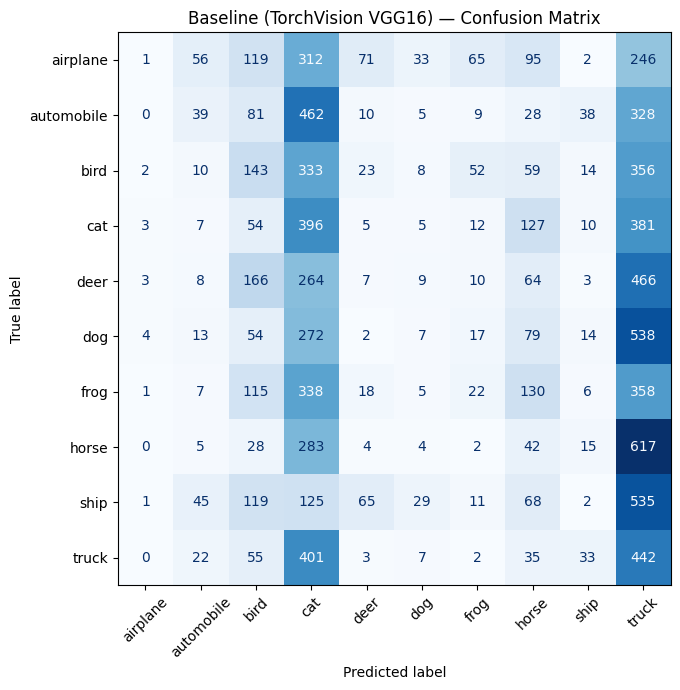

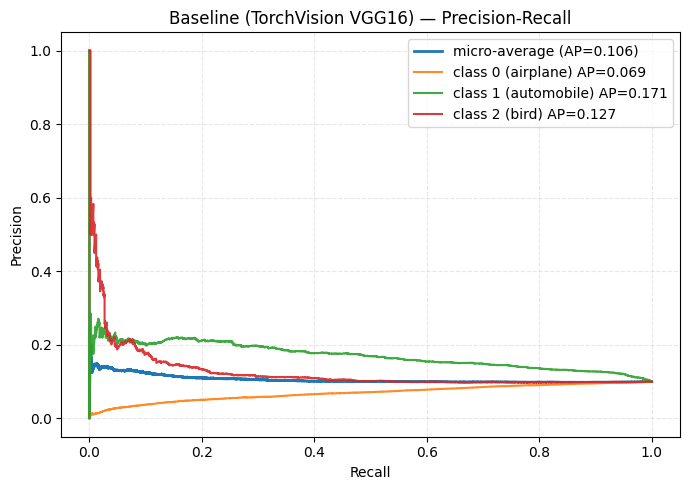

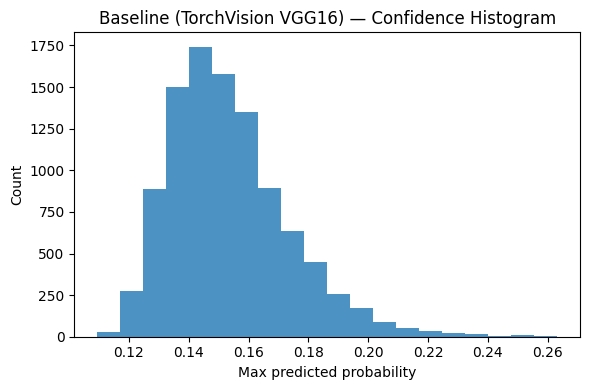


=== Fine-tuned (Provided checkpoint) ===
Loss=0.3781, Acc@1=0.8839

Classification report:
              precision    recall  f1-score   support

    airplane     0.9011    0.9110    0.9060      1000
  automobile     0.9474    0.9360    0.9416      1000
        bird     0.8335    0.8810    0.8566      1000
         cat     0.8693    0.6450    0.7405      1000
        deer     0.8630    0.8570    0.8600      1000
         dog     0.7919    0.8750    0.8314      1000
        frog     0.8653    0.9510    0.9061      1000
       horse     0.9212    0.9000    0.9105      1000
        ship     0.9253    0.9540    0.9394      1000
       truck     0.9318    0.9290    0.9304      1000

    accuracy                         0.8839     10000
   macro avg     0.8850    0.8839    0.8823     10000
weighted avg     0.8850    0.8839    0.8823     10000



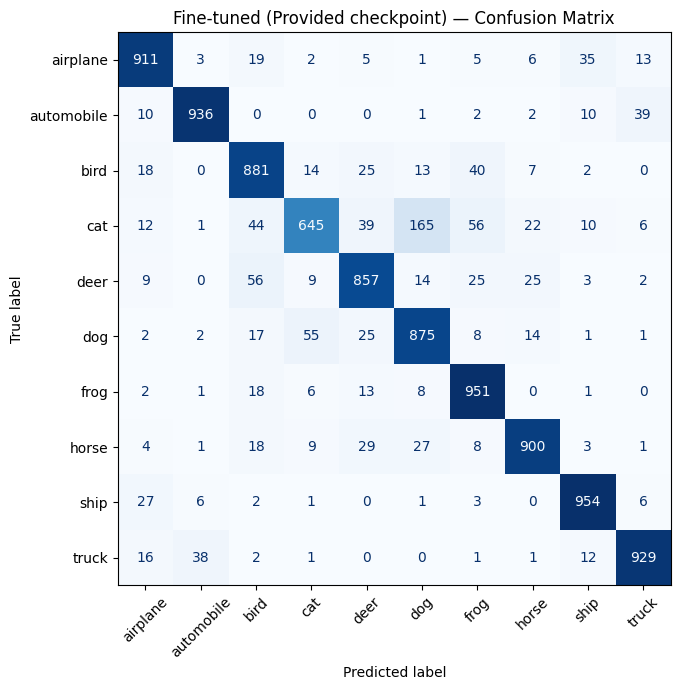

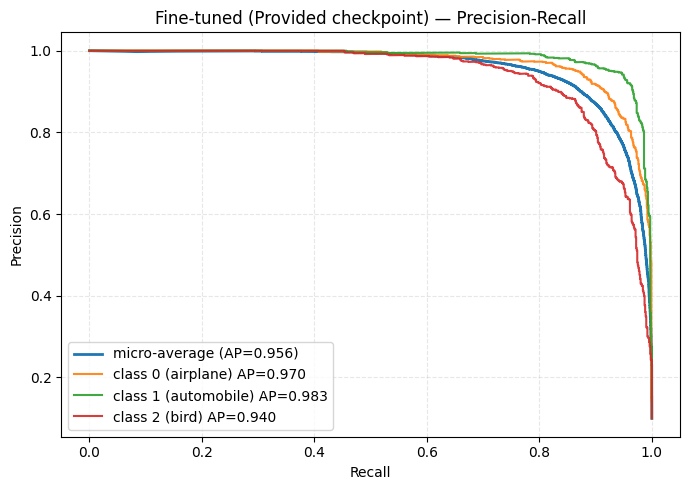

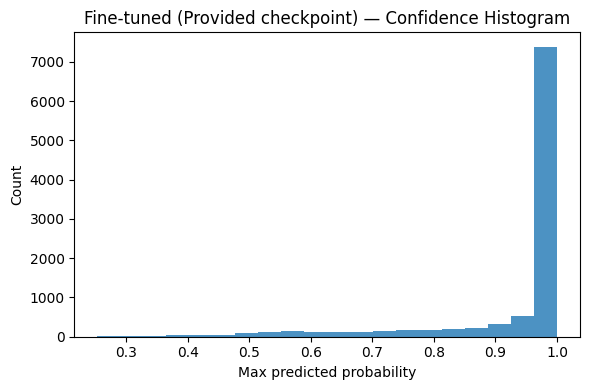

In [11]:
# ---------------------------
# Run all analyses for both models
# ---------------------------
def run_all(model, tag):
    print(f"\n=== {tag} ===")
    loss, acc, y_pred, y_true, y_prob = evaluate(model, test_loader, criterion, device)
    print(f"Loss={loss:.4f}, Acc@1={acc:.4f}")

    # 1) Classification report
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

    # 2) Confusion matrix
    plot_confusion(y_true, y_pred, title=f"{tag} — Confusion Matrix")

    # 3) PR curves (micro + few classes)
    ap = pr_curves(y_true, y_prob, title=f"{tag} — Precision-Recall", show_classes=(0,1,2))

    # 4) Confidence histogram
    confidence_hist(y_prob, title=f"{tag} — Confidence Histogram")

    # 5) Per-class accuracy
    pc = per_class_accuracy(y_true, y_pred)

    return {
        "loss": loss,
        "acc": acc,
        "ap": ap,
        "per_class_acc": pc,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
    }

baseline_res = run_all(baseline, "Baseline (TorchVision VGG16)")
ft_res = run_all(ft_model, "Fine-tuned (Provided checkpoint)")

In [ ]:
epochs = 3
best_acc, best_state = 0.0, None
train_loses, val_loses = [], []

for epoch in range(1, epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device)
    test_loss, test_acc, _, _, _ = evaluate(model, test_loader, criterion, device)

    train_loses.append(train_loss);
    val_loses.append(test_loss)

    if test_acc > best_acc:
        best_acc = test_acc
        best_state = { k: v.cpu().clon() for k, v in model.state_dict().items() }

    print(f"Epoch {epoch:02d} train_loss={train_loss:.4f} train_acc={train_acc:.4f} test_loss={test_loss:.4f} test_acc={test_acc:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)
    model = model.to(device)
print(f"Best test accurcy: {best_acc:4f}")



Qualitative — Baseline


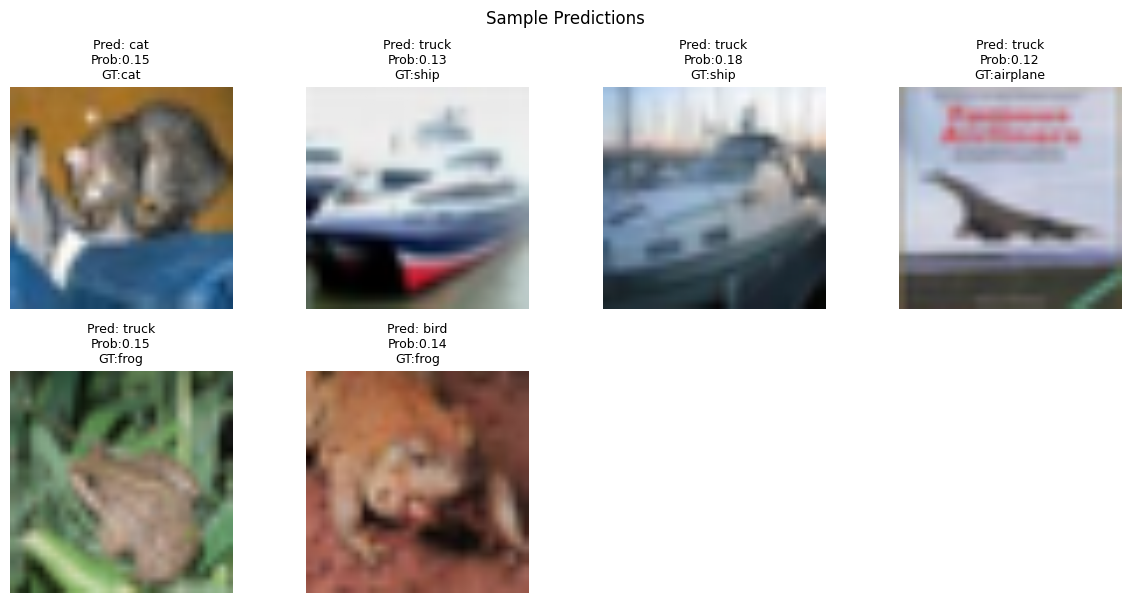


Qualitative — Fine-tuned


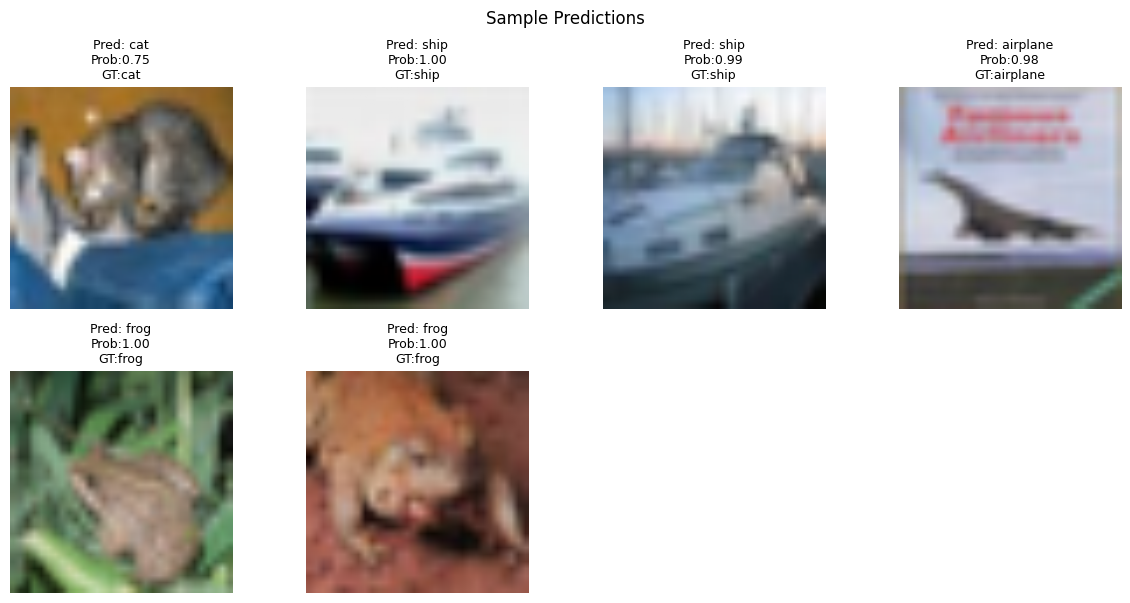

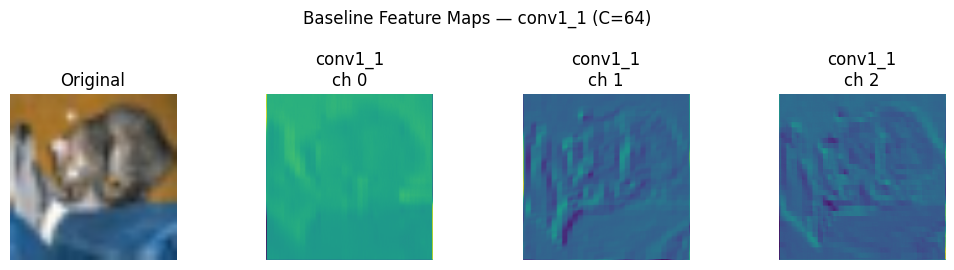

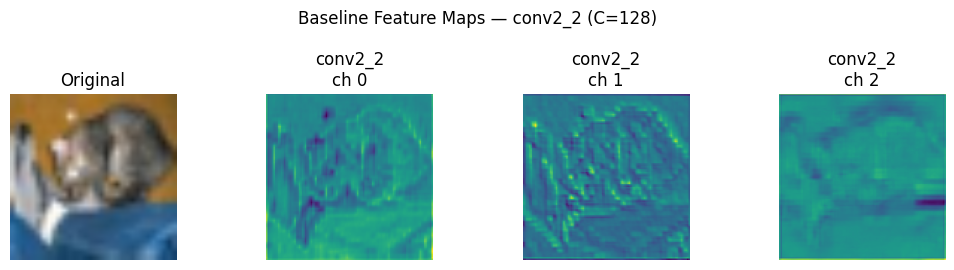

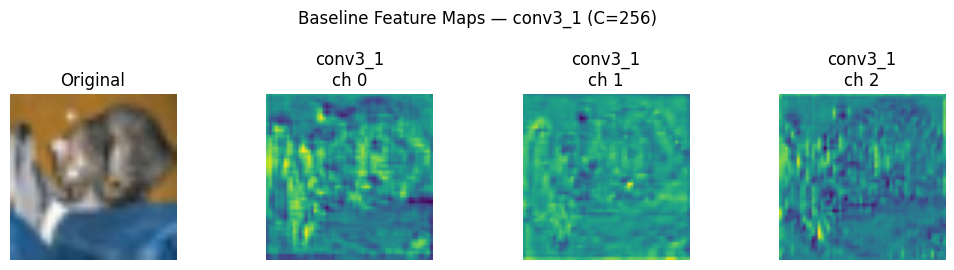

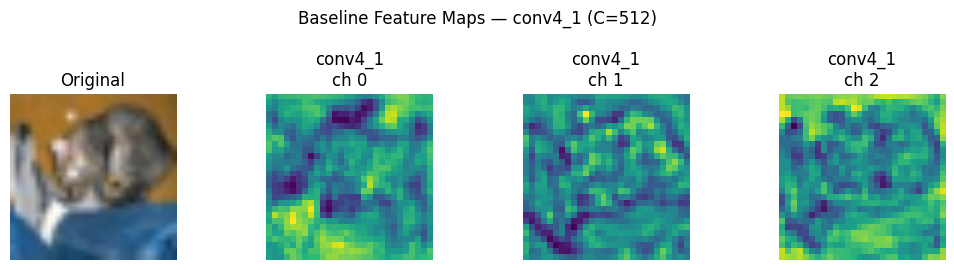

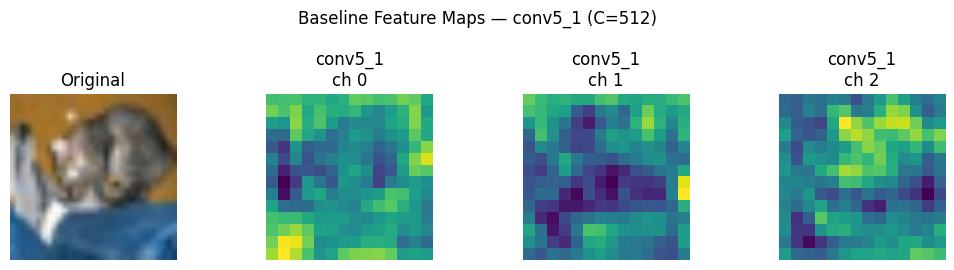

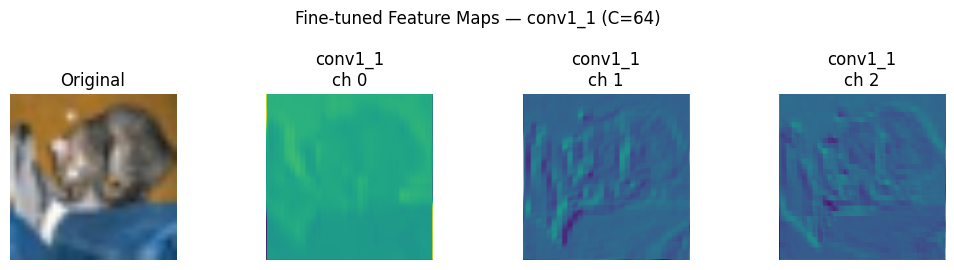

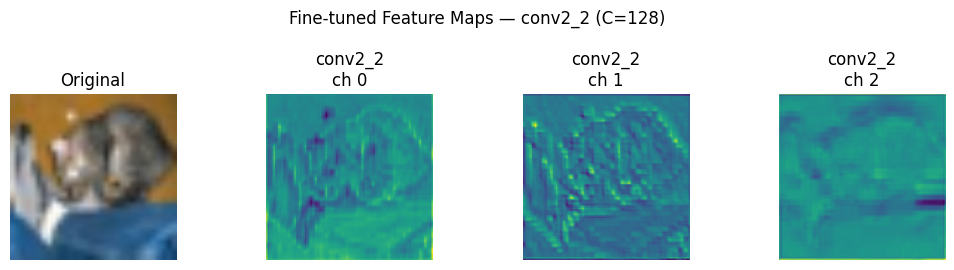

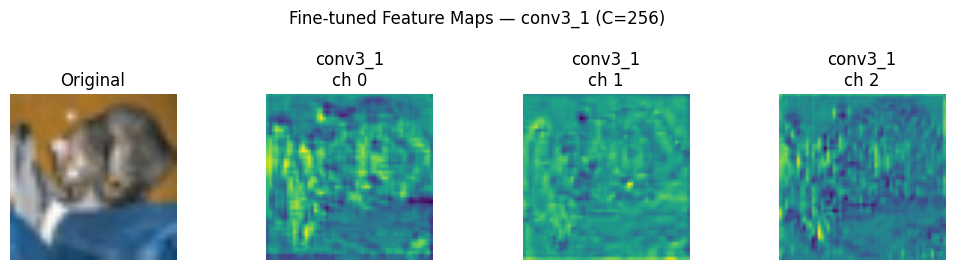

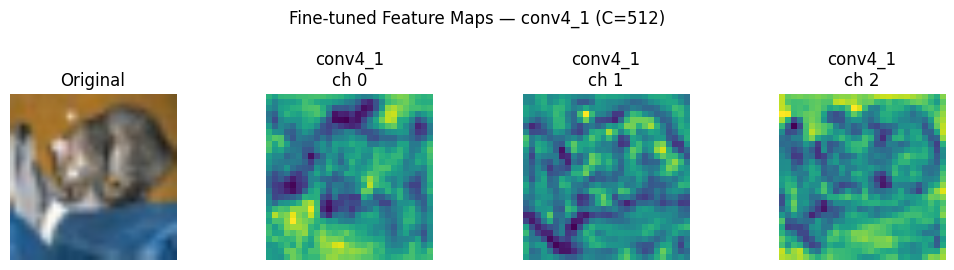

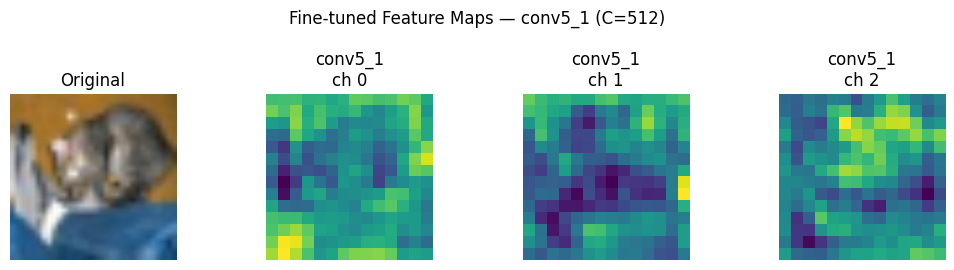

Exercise finished (inference-only).


In [12]:
# ---------------------------
# [TODO checklist for this cell]
#  -- Qualitative: show predictions grid for each model
# ---------------------------

 # [TODO]
@torch.no_grad()
def show_sample_predictions(model, loader, classes, n_images=12):
     # [TODO]
    model.eval()
    shown = 0
    plt.figure(figsize=(12, 9))
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
         # [TODO]
         # [TODO]
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

        for i in range(images.size(0)):
            if shown >= n_images: break
            plt.subplot(3, 4, shown+1)
            img = images[i].detach().cpu()
            for c, m, s in zip(range(3), IMAGENET_MEAN, IMAGENET_STD): img[c] = img[c]*s + m
            img = torch.clamp(img, 0, 1)
            plt.imshow(np.transpose(img.numpy(), (1,2,0)))
            plt.title(f"Pred: {classes[preds[i]]}\nProb:{probs[i,preds[i]].item():.2f}\nGT:{classes[targets[i]]}", fontsize=9)
            plt.axis("off"); shown += 1
        if shown >= n_images: break
    plt.suptitle("Sample Predictions"); plt.tight_layout(); plt.show()

print("\nQualitative — Baseline")
show_sample_predictions(baseline, test_loader, classes, n_images=6)
print("\nQualitative — Fine-tuned")
show_sample_predictions(ft_model, test_loader, classes, n_images=6)

# Feature maps (side-by-side) for one image, both models
sample_img, _ = test_set[0]
x = sample_img.unsqueeze(0).to(device)
acts_base = run_and_capture_features(baseline, x, set(LAYER_IDXS.values()))
acts_ft = run_and_capture_features(ft_model, x, set(LAYER_IDXS.values()))
show_feature_maps_with_original(sample_img, acts_base, max_channels=3, title_prefix="Baseline")
show_feature_maps_with_original(sample_img, acts_ft,   max_channels=3, title_prefix="Fine-tuned")

print("Exercise finished (inference-only).")

# Implement the training epoch

In my original exercise, I don't know where should I implement or call the training epoch. Then I ask GPT to help me to point out where should I implement it and also write the solution as a single panel solution. 


Device: cuda


100%|██████████| 170M/170M [00:05<00:00, 29.3MB/s]


Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Mounted at /content/drive
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 133MB/s]


[OK] Loaded checkpoint from: /content/drive/MyDrive/2025/NTUST/Fall 2025/DL CV/Exercise 2/vgg16_cifar10.pth
[OK] Loaded checkpoint from: /content/drive/MyDrive/2025/NTUST/Fall 2025/DL CV/Exercise 2/vgg16_cifar10.pth


/tmp/ipython-input-2939971984.py:383: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
/tmp/ipython-input-2939971984.py:206: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 01 train_loss=nan train_acc=0.1053 test_loss=337778.2934 test_acc=0.0872 lr=0.007500
Epoch 02 train_loss=nan train_acc=0.1000 test_loss=337778.2744 test_acc=0.0872 lr=0.002500
Epoch 03 train_loss=nan train_acc=0.1000 test_loss=337778.2744 test_acc=0.0872 lr=0.000000
Best test accuracy: 0.0872
Best checkpoint path: /content/drive/MyDrive/2025/NTUST/Fall 2025/DL CV/Exercise 2/vgg16_cifar10_FINETUNED_best.pth

=== Baseline (TorchVision VGG16) — Eval Only ===

=== Baseline (TorchVision VGG16) ===
Loss=2.3384, Acc@1=0.1101

Classification report:
              precision    recall  f1-score   support

    airplane     0.0667    0.0010    0.0020      1000
  automobile     0.1840    0.0390    0.0644      1000
        bird     0.1531    0.1430    0.1479      1000
         cat     0.1243    0.3960    0.1892      1000
        deer     0.0337    0.0070    0.0116      1000
         dog     0.0625    0.0070    0.0126      1000
        frog     0.1089    0.0220    0.0366      1000
       horse 

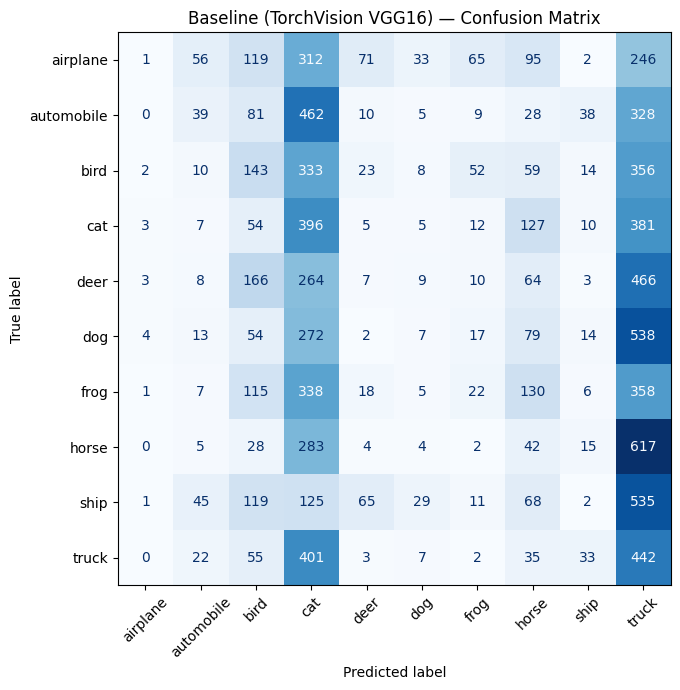

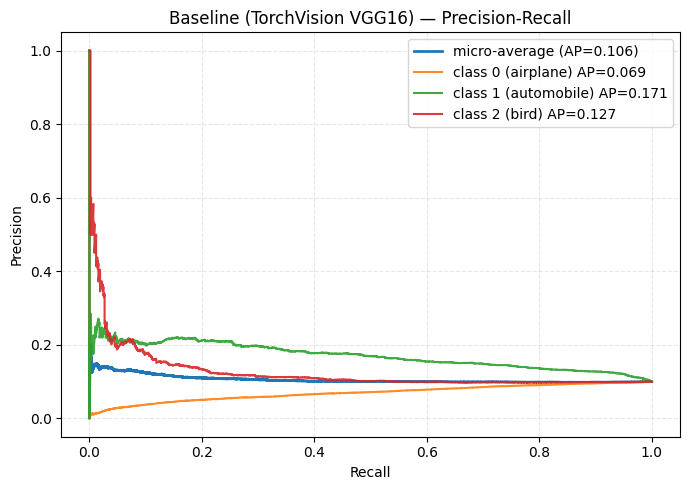

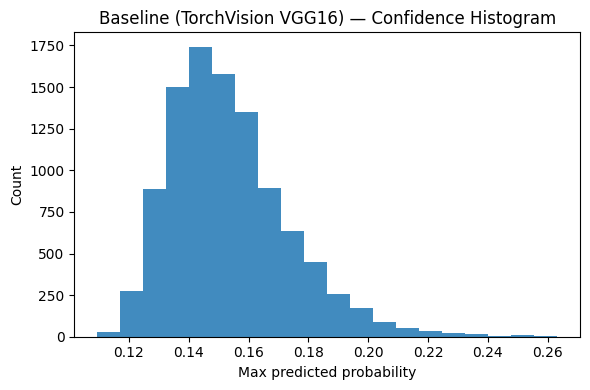


=== Fine-tuned (Provided checkpoint) — Eval Only ===

=== Fine-tuned (Provided checkpoint) ===
Loss=0.3781, Acc@1=0.8839

Classification report:
              precision    recall  f1-score   support

    airplane     0.9011    0.9110    0.9060      1000
  automobile     0.9474    0.9360    0.9416      1000
        bird     0.8335    0.8810    0.8566      1000
         cat     0.8693    0.6450    0.7405      1000
        deer     0.8630    0.8570    0.8600      1000
         dog     0.7919    0.8750    0.8314      1000
        frog     0.8653    0.9510    0.9061      1000
       horse     0.9212    0.9000    0.9105      1000
        ship     0.9253    0.9540    0.9394      1000
       truck     0.9318    0.9290    0.9304      1000

    accuracy                         0.8839     10000
   macro avg     0.8850    0.8839    0.8823     10000
weighted avg     0.8850    0.8839    0.8823     10000



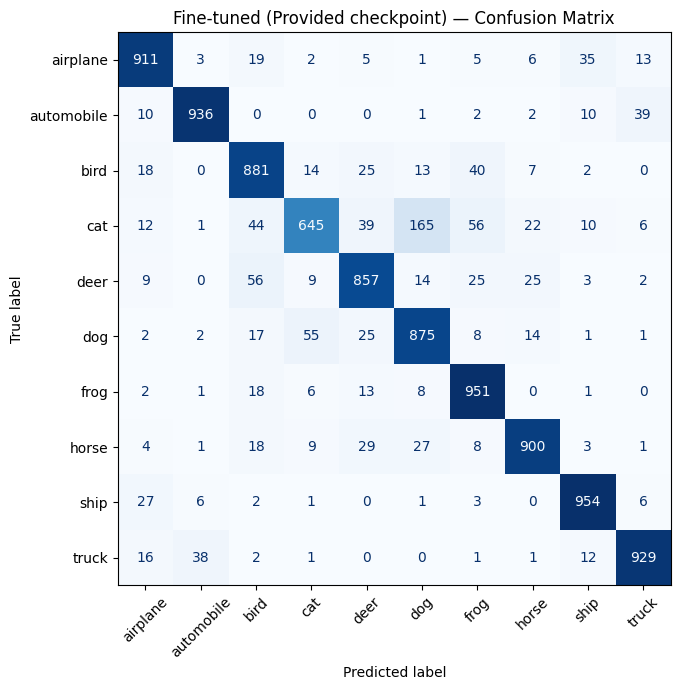

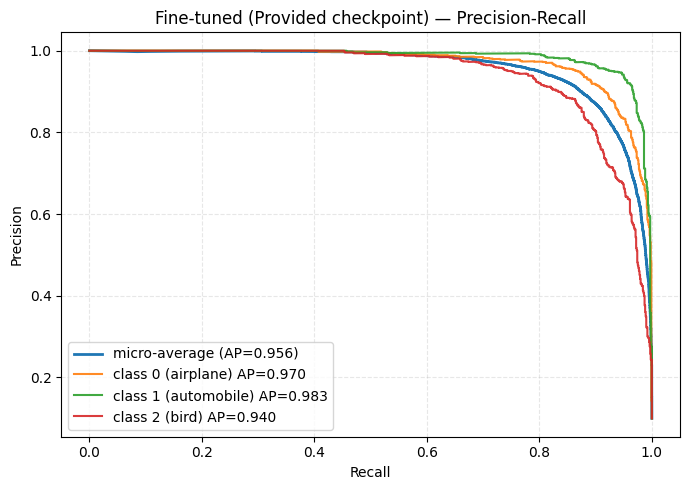

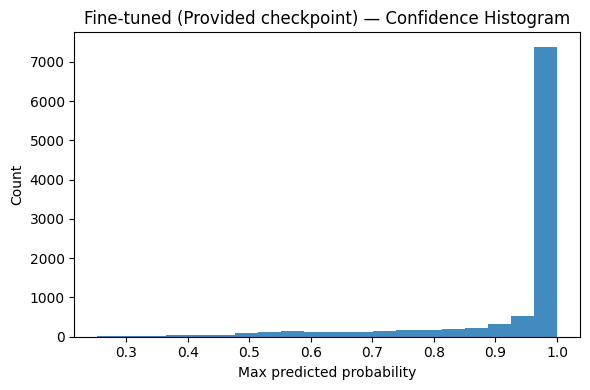


=== Trained model (this run) ===

=== This run — Trained Model ===
Loss=337778.2744, Acc@1=0.0872

Classification report:
              precision    recall  f1-score   support

    airplane     0.0000    0.0000    0.0000      1000
  automobile     0.0000    0.0000    0.0000      1000
        bird     0.0000    0.0000    0.0000      1000
         cat     0.0000    0.0000    0.0000      1000
        deer     0.0000    0.0000    0.0000      1000
         dog     0.0000    0.0000    0.0000      1000
        frog     0.0147    0.0130    0.0138      1000
       horse     0.0000    0.0000    0.0000      1000
        ship     0.0000    0.0000    0.0000      1000
       truck     0.0943    0.8590    0.1699      1000

    accuracy                         0.0872     10000
   macro avg     0.0109    0.0872    0.0184     10000
weighted avg     0.0109    0.0872    0.0184     10000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


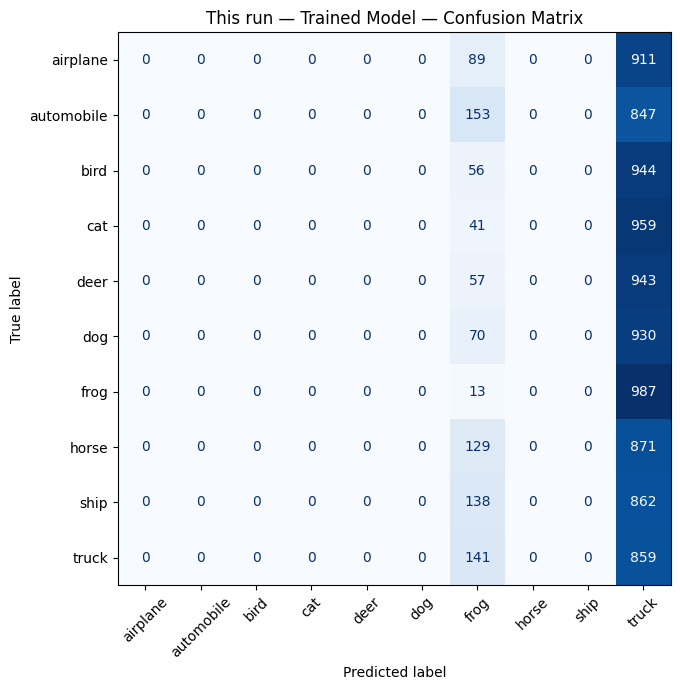

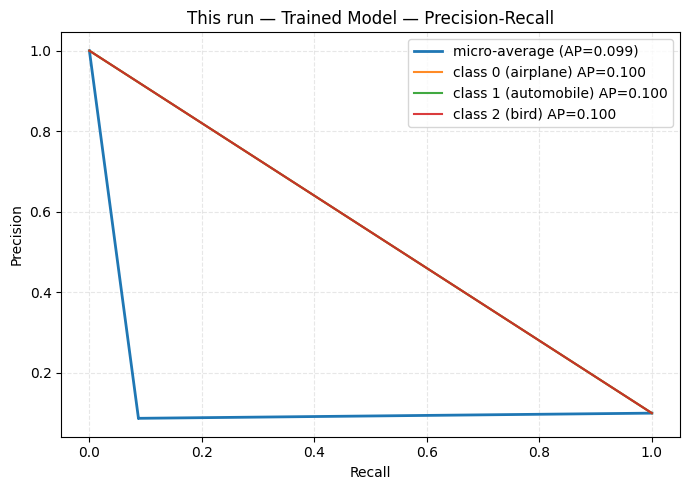

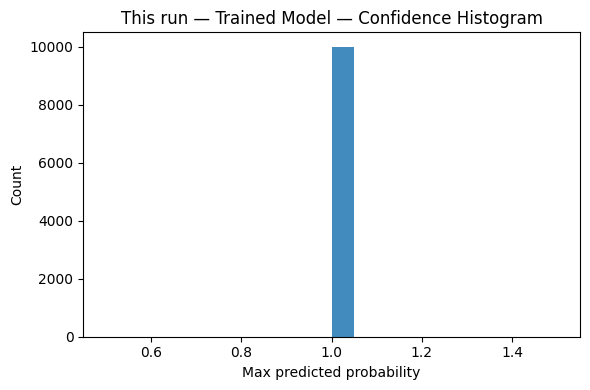


Qualitative — Sample Predictions (This run)


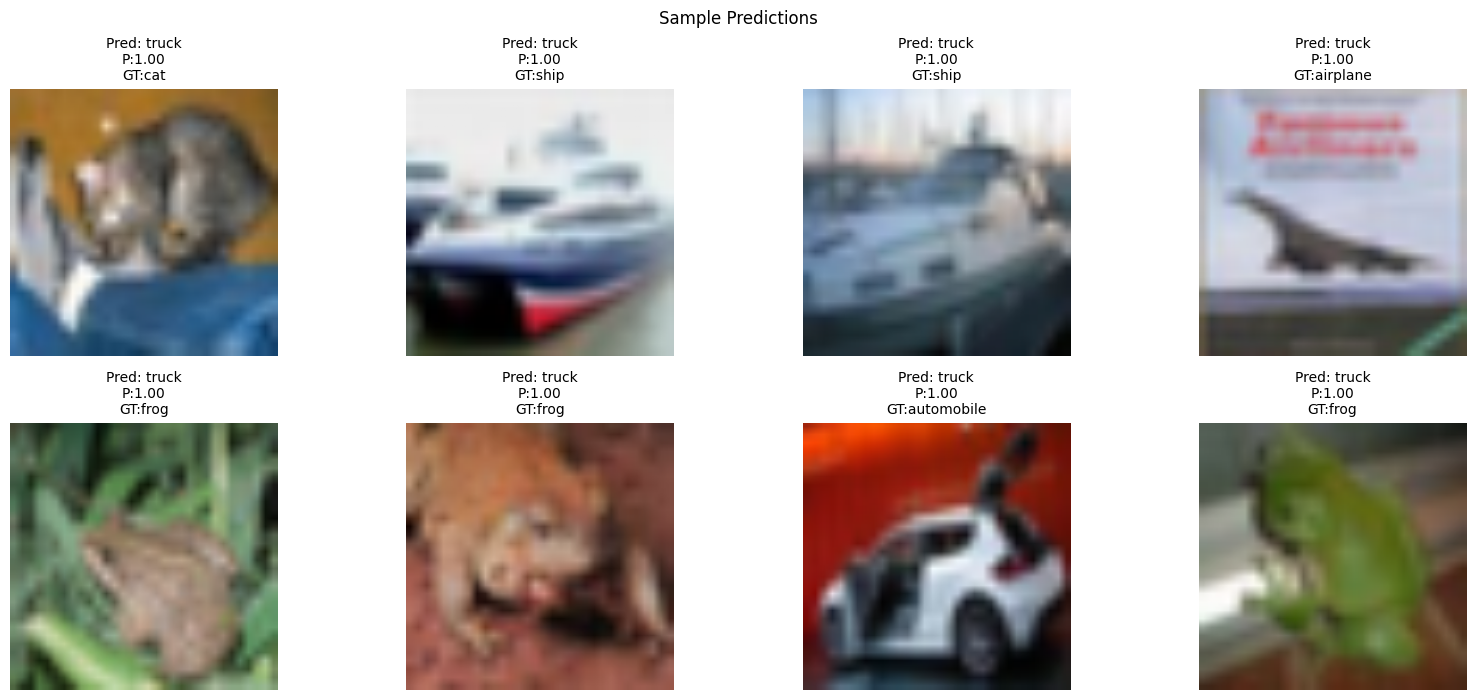

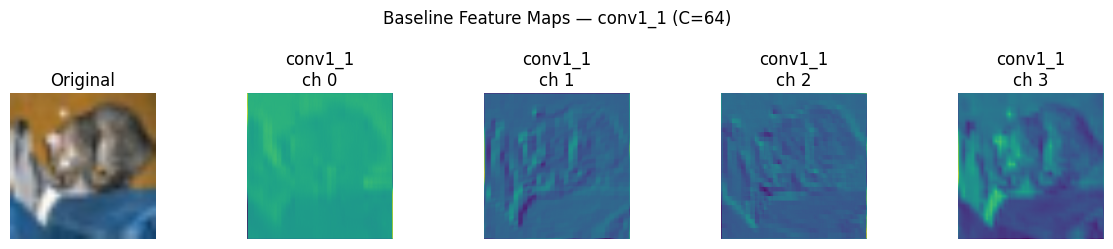

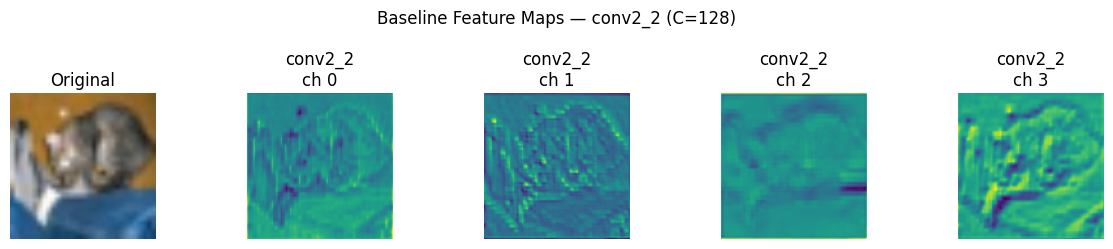

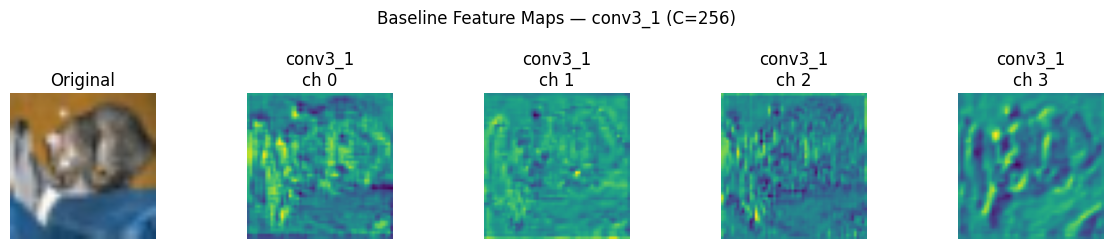

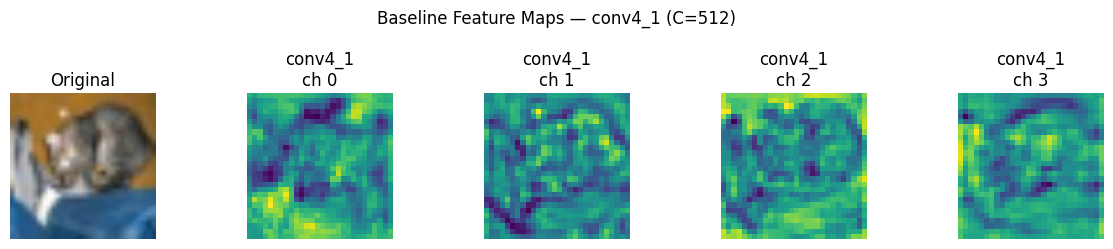

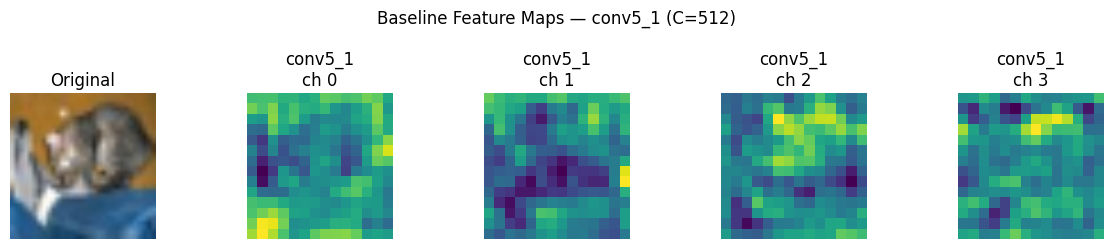

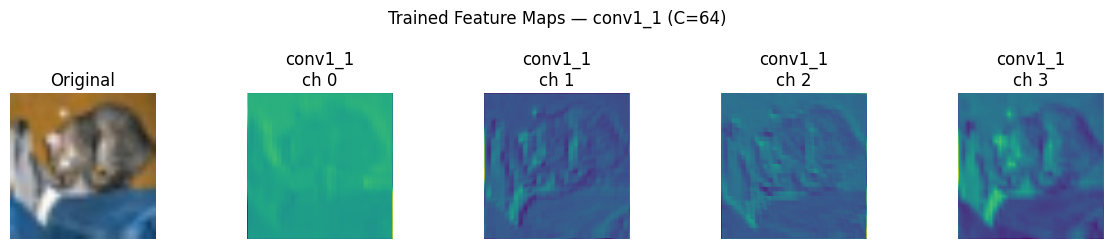

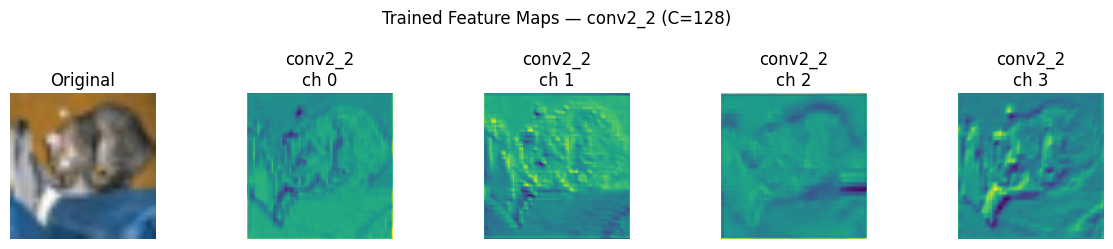

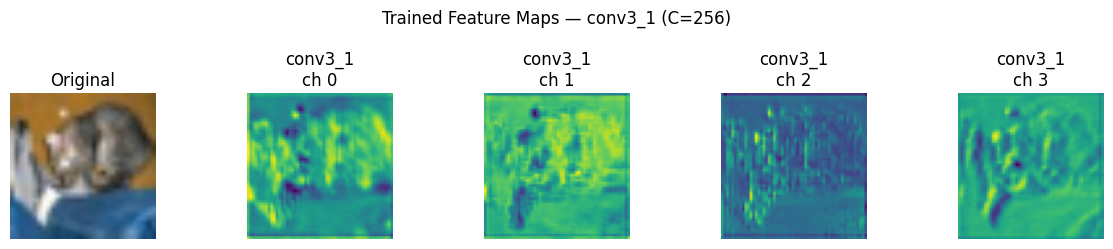

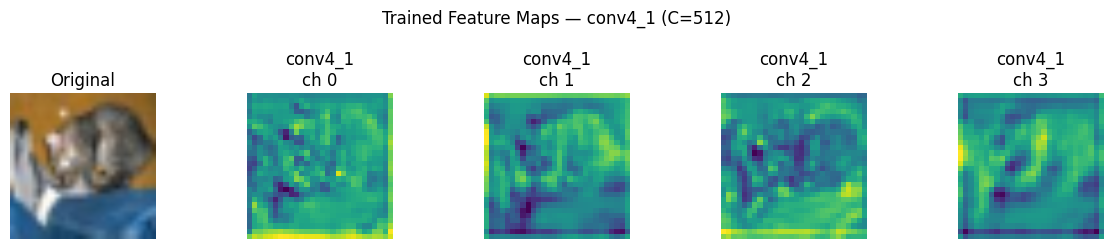

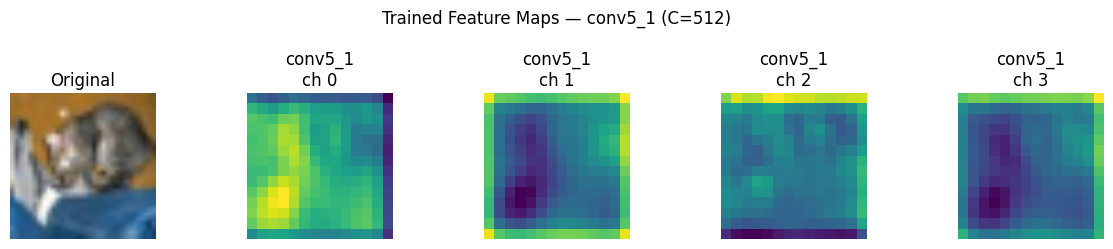

Done.


In [1]:
# ============================================================
# CIFAR-10 + VGG16 (TorchVision / Fine-tuned CKPT / Custom)
# End-to-end: data, training, evaluation, visuals
# Compatible with Colab GPU (mixed precision enabled)
# ============================================================

# ------------ Imports ------------
import os, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# ------------ Reproducibility ------------
def set_seed(seed: int = 23):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(23)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ============================================================
# Data
# ============================================================
# VGG16 head expects 224x224, so we Resize to 224.
# You can switch to 32x32 training if you redesign the head.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

test_tfms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

data_root = "./data"
train_set  = CIFAR10(root=data_root, train=True,  download=True, transform=train_tfms)
test_set   = CIFAR10(root=data_root, train=False, download=True, transform=test_tfms)
classes = train_set.classes
print("Number of classes:", len(classes))
print("Classes:", classes)

batch_size = 128
num_workers = 2
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# ============================================================
# Models
# ============================================================
# ---- VGG block & Custom VGG16-like (optional from-scratch training) ----
class VGGBlock(nn.Module):
    def __init__(self, in_ch, out_ch, n_convs=2, use_pool=True):
        super().__init__()
        layers = []
        curr_in = in_ch
        for _ in range(n_convs):
            layers.append(nn.Conv2d(curr_in, out_ch, kernel_size=3, padding=1, stride=1))
            layers.append(nn.ReLU(inplace=True))
            curr_in = out_ch
        if use_pool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)
    def forward(self, x):
        return self.block(x)

class VGG16Like(nn.Module):
    """
    Mimics VGG16 feature stack and classifier sizes for 224x224 inputs.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        cfg = [64, 64, 'M',
               128, 128, 'M',
               256, 256, 256, 'M',
               512, 512, 512, 'M',
               512, 512, 512, 'M']
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                layers.append(nn.Conv2d(in_channels, v, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                in_channels = v
        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ---- TorchVision VGG16 helpers (baseline / fine-tuned) ----
def build_torchvision_vgg16(num_classes=10):
    from torchvision.models import vgg16
    try:
        from torchvision.models import VGG16_Weights
        model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    except Exception:
        # older torchvision fallback
        model = vgg16(pretrained=True)
    in_f = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_f, num_classes)
    return model

def build_finetuned_from_ckpt(ckpt_path, num_classes=10, map_location="cpu"):
    model = build_torchvision_vgg16(num_classes=num_classes)
    try:
        state = torch.load(ckpt_path, map_location=map_location)
        if isinstance(state, dict) and "state_dict" in state:
            # in case the dict is nested like {"state_dict": ...}
            state = {k.replace("model.", "").replace("module.", ""): v
                     for k, v in state["state_dict"].items()}
        model.load_state_dict(state, strict=False)
        print(f"[OK] Loaded checkpoint from: {ckpt_path}")
    except Exception as e:
        print(f"[WARN] Could not load checkpoint at {ckpt_path}: {e}")
    return model

# (Optional) Mount Drive if you keep checkpoints there
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    on_colab = True
except Exception:
    on_colab = False

CKPT_PATH = "/content/drive/MyDrive/2025/NTUST/Fall 2025/DL CV/Exercise 2/vgg16_cifar10.pth"

# Build three variants (two are eval-only baselines; one will be trained below)
baseline = build_torchvision_vgg16(num_classes=len(classes)).to(device).eval()
ft_model = build_finetuned_from_ckpt(CKPT_PATH, num_classes=len(classes), map_location=device).to(device).eval()

# ============================================================
# Training + Evaluation
# ============================================================
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_preds, all_targets, all_probs = [], [], []
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        total_loss += loss.item() * images.size(0)
        correct += (preds == targets).sum().item()
        total += images.size(0)
        all_preds.append(preds.cpu())
        all_targets.append(targets.cpu())
        all_probs.append(probs.cpu())
    all_preds   = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_probs   = torch.cat(all_probs).numpy()
    return (total_loss/total,
            correct/total,
            all_preds,
            all_targets,
            all_probs)

# ---------- Training helpers ----------
from copy import deepcopy

def train_one_epoch(model, loader, optimizer, device, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        if scaler is not None:
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(images)
                loss = criterion(logits, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(images)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            preds = logits.argmax(dim=1)
            running_loss += loss.item() * images.size(0)
            correct += (preds == targets).sum().item()
            total += images.size(0)
    return running_loss/total, correct/total

def run_all(model, tag):
    print(f"\n=== {tag} ===")
    loss, acc, y_pred, y_true, y_prob = evaluate(model, test_loader, criterion, device)
    print(f"Loss={loss:.4f}, Acc@1={acc:.4f}")

    # 1) Classification report
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

    # 2) Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classes)
    fig, ax = plt.subplots(figsize=(7,7))
    disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
    plt.title(f"{tag} — Confusion Matrix"); plt.tight_layout(); plt.show()

    # 3) PR curves (micro + few classes)
    y_true_bin = label_binarize(y_true, classes=np.arange(len(classes)))
    precision, recall, ap = {}, {}, {}
    for c in range(len(classes)):
        precision[c], recall[c], _ = precision_recall_curve(y_true_bin[:, c], y_prob[:, c])
        ap[c] = average_precision_score(y_true_bin[:, c], y_prob[:, c])
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_prob.ravel())
    ap["micro"] = average_precision_score(y_true_bin, y_prob, average="micro")

    plt.figure(figsize=(7,5))
    plt.plot(recall["micro"], precision["micro"], linewidth=2, label=f"micro-average (AP={ap['micro']:.3f})")
    for c in (0,1,2):
        plt.plot(recall[c], precision[c], label=f"class {c} ({classes[c]}) AP={ap[c]:.3f}", alpha=0.9)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{tag} — Precision-Recall"); plt.legend()
    plt.grid(True, ls="--", alpha=0.3); plt.tight_layout(); plt.show()

    # 4) Confidence histogram
    conf = y_prob.max(axis=1)
    plt.figure(figsize=(6,4))
    plt.hist(conf, bins=20, alpha=0.85)
    plt.xlabel("Max predicted probability"); plt.ylabel("Count"); plt.title(f"{tag} — Confidence Histogram")
    plt.tight_layout(); plt.show()

    # 5) Per-class accuracy
    y_true_arr = np.asarray(y_true); y_pred_arr = np.asarray(y_pred)
    per_class_acc = {}
    for cid, name in enumerate(classes):
        mask = (y_true_arr == cid)
        per_class_acc[name] = float((y_pred_arr[mask] == cid).mean())

    return {
        "loss": loss,
        "acc": acc,
        "ap": ap,
        "per_class_acc": per_class_acc,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_prob,
    }

@torch.no_grad()
def show_sample_predictions(model, loader, classes, n_images=12):
    model.eval()
    shown = 0
    rows, cols = 3, 4
    plt.figure(figsize=(4*cols, 3.5*rows))
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        logits = model(images)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        for i in range(images.size(0)):
            if shown >= n_images: break
            plt.subplot(rows, cols, shown+1)
            img = images[i].detach().cpu()
            for c, m, s in zip(range(3), IMAGENET_MEAN, IMAGENET_STD):
                img[c] = img[c]*s + m
            img = torch.clamp(img, 0, 1)
            plt.imshow(np.transpose(img.numpy(), (1,2,0)))
            plt.title(f"Pred: {classes[preds[i]]}\nP:{probs[i,preds[i]].item():.2f}\nGT:{classes[targets[i]]}", fontsize=10)
            plt.axis("off"); shown += 1
        if shown >= n_images: break
    plt.suptitle("Sample Predictions"); plt.tight_layout(); plt.show()

# ============================================================
# Feature maps
# ============================================================
LAYER_IDXS = {
    "conv1_1": 0,
    "conv2_2": 5,
    "conv3_1": 10,
    "conv4_1": 17,
    "conv5_1": 24,
}
IDX_TO_NAME = {idx: name for name, idx in LAYER_IDXS.items()}

def denormalize_img(img_chw):
    x = img_chw.clone()
    for c, m, s in zip(range(3), IMAGENET_MEAN, IMAGENET_STD):
        x[c] = x[c] * s + m
    return torch.clamp(x, 0, 1)

@torch.no_grad()
def run_and_capture_features(model, x, layer_idxs):
    model.eval()
    feats = {}
    out = x
    # works for models with .features (TorchVision VGG16 & our VGG16Like)
    for i, layer in enumerate(model.features):
        out = layer(out)
        if i in layer_idxs:
            name = IDX_TO_NAME[i]
            feats[name] = out.detach().cpu()
    return feats

def show_feature_maps_with_original(original_img_chw, acts_dict, max_channels=6, title_prefix=""):
    orig = denormalize_img(original_img_chw).numpy()
    orig = np.transpose(orig, (1,2,0))
    for name, feat in acts_dict.items():
        fmap = feat[0]; C = fmap.shape[0]; n = min(max_channels, C)
        cols = 1 + n
        fig, axes = plt.subplots(1, cols, figsize=(2.4*cols, 2.4))
        axes = axes.ravel()
        axes[0].imshow(orig); axes[0].set_title("Original"); axes[0].axis("off")
        for i in range(n):
            ch = fmap[i]
            ch = (ch - ch.min()) / (ch.max() - ch.min() + 1e-5)
            axes[1+i].imshow(ch.numpy(), cmap="viridis"); axes[1+i].set_title(f"{name}\nch {i}")
            axes[1+i].axis("off")
        plt.suptitle(f"{title_prefix} Feature Maps — {name} (C={C})", y=1.02)
        plt.tight_layout(); plt.show()

# ============================================================
# Choose & Train a model
# ============================================================
# Options:
#   TRAIN_CHOICE = 'ft'      -> start from provided fine-tuned checkpoint, keep fine-tuning
#   TRAIN_CHOICE = 'tv'      -> start from TorchVision VGG16 (ImageNet), fine-tune
#   TRAIN_CHOICE = 'custom'  -> train the custom VGG16Like from scratch
TRAIN_CHOICE = 'ft'   # <- change if you want

if TRAIN_CHOICE == 'ft':
    model = build_finetuned_from_ckpt(CKPT_PATH, num_classes=len(classes), map_location=device).to(device)
elif TRAIN_CHOICE == 'tv':
    model = build_torchvision_vgg16(num_classes=len(classes)).to(device)
elif TRAIN_CHOICE == 'custom':
    model = VGG16Like(num_classes=len(classes)).to(device)
else:
    raise ValueError("TRAIN_CHOICE must be one of: 'ft', 'tv', 'custom'")

# Optional: freeze early layers to speed up training on small data/time budgets
# for p in model.features.parameters():
#     p.requires_grad = False

# Optimizer / Scheduler / Mixed precision
epochs = 3
base_lr = 0.01
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=base_lr, momentum=0.9, weight_decay=5e-4, nesterov=True
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

best_acc, best_state = 0.0, None
train_losses, val_losses = [], []

BEST_CKPT_OUT = "/content/drive/MyDrive/2025/NTUST/Fall 2025/DL CV/Exercise 2/vgg16_cifar10_FINETUNED_best.pth"

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, scaler=scaler)
    test_loss, test_acc, _, _, _ = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(test_loss)

    if test_acc > best_acc:
        best_acc = test_acc
        best_state = deepcopy(model.state_dict())
        try:
            torch.save(best_state, BEST_CKPT_OUT)
        except Exception as e:
            print(f"[WARN] Could not save to {BEST_CKPT_OUT}: {e}")

    if scheduler is not None:
        scheduler.step()

    print(f"Epoch {epoch:02d} "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
          f"test_loss={test_loss:.4f} test_acc={test_acc:.4f} "
          f"lr={optimizer.param_groups[0]['lr']:.6f}")

if best_state is not None:
    model.load_state_dict(best_state)
    model = model.to(device)
print(f"Best test accuracy: {best_acc:.4f}")
if on_colab:
    print(f"Best checkpoint path: {BEST_CKPT_OUT}")

# ============================================================
# Evaluation & Visuals
# ============================================================
print("\n=== Baseline (TorchVision VGG16) — Eval Only ===")
_ = run_all(baseline, "Baseline (TorchVision VGG16)")

print("\n=== Fine-tuned (Provided checkpoint) — Eval Only ===")
_ = run_all(ft_model, "Fine-tuned (Provided checkpoint)")

print("\n=== Trained model (this run) ===")
trained_res = run_all(model, "This run — Trained Model")

print("\nQualitative — Sample Predictions (This run)")
show_sample_predictions(model, test_loader, classes, n_images=8)

# Feature maps for one sample (both baseline and current trained model)
sample_img, _ = test_set[0]
x = sample_img.unsqueeze(0).to(device)

# Some TorchVision models store features under .features; our code assumes that.
# If you've chosen TRAIN_CHOICE='custom' or 'tv', it works. If you changed the architecture, adjust accordingly.
acts_base = run_and_capture_features(baseline, x, set(LAYER_IDXS.values()))
acts_tr   = run_and_capture_features(model,    x, set(LAYER_IDXS.values()))
show_feature_maps_with_original(sample_img, acts_base, max_channels=4, title_prefix="Baseline")
show_feature_maps_with_original(sample_img, acts_tr,   max_channels=4, title_prefix="Trained")
print("Done.")
